In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Dealing with missing data

In [3]:
from io import StringIO
csv_data = """
A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,
"""

df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [4]:
# Identifying missing value in tabular data
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

In [5]:
# Eliminating records or features

# 1. Eliminating records
print(df.dropna(axis=0))

# 2. Eliminating features
print(df.dropna(axis=1))

     A    B    C    D
0  1.0  2.0  3.0  4.0
      A     B
0   1.0   2.0
1   5.0   6.0
2  10.0  11.0


In [6]:
# Eliminating records (more complex)

# a. Only drop rows where all columns are NaN
print(df.dropna(how='all'))
# Note: since we don't have a row with all values NaN, it returns
#        whole array.

# b.drop rows that have fewer than a number (in this example 4) 
#     of real values
print(df.dropna(thresh=4))

# c. only drop rows where NaN appear in specific columns (here: 'C')
print(df.dropna(subset=['C']))

      A     B     C    D
0   1.0   2.0   3.0  4.0
1   5.0   6.0   NaN  8.0
2  10.0  11.0  12.0  NaN
     A    B    C    D
0  1.0  2.0  3.0  4.0
      A     B     C    D
0   1.0   2.0   3.0  4.0
2  10.0  11.0  12.0  NaN


# Imputing missing values

In [7]:
# Impute missing value with mean
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(df.values)
imputed_data = imp.transform(df.values) # Return numpy array
imputed_data = pd.DataFrame(imputed_data, columns=df.columns)
imputed_data

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,7.5,8.0
2,10.0,11.0,12.0,6.0


# Categorical data encoding with pandas

In [8]:
df = pd.DataFrame([
    ['green', 'M', 10.1, 'class2'],
    ['red', 'L', 13.5, 'class1'],
    ['blue', 'XL', 15.3, 'class2']])
df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


**1. Mapping ordinal features**

In [9]:
size_mapping = {'XL': 3, 'L': 2, 'M': 1}
df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


**2. Encoding labels (using LabelEncoder)**

In [10]:
from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values)
y

array([1, 0, 1])

In [11]:
# Inverse transfrom
class_le.inverse_transform(y)

array(['class2', 'class1', 'class2'], dtype=object)

**3.One Hot Encoding on Nominal Features**

In [12]:
from sklearn.preprocessing import OneHotEncoder
# NOTE: OneHotEncoder will convert all features (numerical and categorical)
X = df[['color', 'size', 'price']].values
color_ohe = OneHotEncoder()
color_transformed = color_ohe\
                    .fit_transform(X[:, 0].reshape(-1, 1))\
                    .toarray() # make sure it is 2D
color_transformed_features = color_ohe.get_feature_names_out()
pd.DataFrame(color_transformed, columns=color_transformed_features)


,x0_blue,x0_green,x0_red
0,0.0,1.0,0.0
1,0.0,0.0,1.0
2,1.0,0.0,0.0


In [13]:
# One Hot Encoding multi-feature (using ColumnTransformer)
from sklearn.compose import ColumnTransformer
X = df[['color', 'size', 'price']].values
c_transf = ColumnTransformer([
    ('onehot', OneHotEncoder(), [0]),
    ('nothing', 'passthrough', [1, 2])
])

X_transformed = c_transf.fit_transform(X).astype(float)
color_transformed_features = c_transf\
                                .named_transformers_['onehot']\
                                .get_feature_names_out()
feature_names = np.concatenate((color_transformed_features,
                                df.columns[[1, 2]].values))

pd.DataFrame(X_transformed, columns=feature_names)

,x0_blue,x0_green,x0_red,size,price
0,0.0,1.0,0.0,1.0,10.1
1,0.0,0.0,1.0,2.0,13.5
2,1.0,0.0,0.0,3.0,15.3


In [14]:
# Encoder with pandas get_dummies
# NOTE: it only convert string columns and leave all other
pd.get_dummies(df[['price', 'color', 'size']])

,price,size,color_blue,color_green,color_red
0,10.1,1,0,1,0
1,13.5,2,0,0,1
2,15.3,3,1,0,0


NOTE:
- Jika fitur-fitur hasil OneHotEncoding highly correlated, kita bisa mereduksinya dengan cara menghilangkan salah satunya.

In [15]:
# Example code with pandas get_dummies
pd.get_dummies(df[['price', 'color', 'size']],
              drop_first=True)


,price,size,color_green,color_red
0,10.1,1,1,0
1,13.5,2,0,1
2,15.3,3,0,0


In [16]:
# Example code with OneHotEncoder

color_ohe = OneHotEncoder(categories='auto', drop='first')
c_transf = ColumnTransformer([('onehot', color_ohe, [0]),
                             ('nothing', 'passthrough', [1, 2])])

c_transf.fit_transform(X).astype(float)

array([[ 1. ,  0. ,  1. , 10.1],
       [ 0. ,  1. ,  2. , 13.5],
       [ 0. ,  0. ,  3. , 15.3]])

# Partitioning a dataset into separate training and test datasets

In [17]:
df_wine = pd.read_csv(
    'https://archive.ics.uci.edu/ml/'
    'machine-learning-databases/wine/wine.data',
    header=None)

df_wine.columns = ['Class label', 'Alcohol',
                   'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium',
                   'Total phenols', 'Flavanoids',
                   'Nonflavanoid phenols',
                   'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines',
                   'Proline']

df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [18]:
# A convenient way ==> Using train_test_split

from sklearn.model_selection import train_test_split
X, y =df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test =\
        train_test_split(X, y,
                         test_size=0.3,
                         random_state=42,
                         stratify=y)
# Note: "stratify" ensures that both training and test datasets
#         have the same class proportions as the original dataset

print('Initial y :', np.unique(y, return_counts=True)[-1])
print('y_train :', np.unique(y_train, return_counts=True)[-1])
print('y_test :', np.unique(y_test, return_counts=True)[-1])

Initial y : [59 71 48]
y_train : [41 50 33]
y_test : [18 21 15]


NOTE:
- Common splits ==> 60:40, 70:30, or 80:20
- For large datasets ==> 90:1, 99:1

# Feature Scaling
- Beberapa algoritma seperti Decision Tree and Random Forest tidak memerlukan feature scaling, tapi mayoritas algoritma lainnya dapat bekerja dengan baik pada fitur dengan skala yang sama.

- Normalization: Merubah nilai fitur-fitur menjadi nilai pada rentan [0, 1]
- Standardization: Merubah nilai fitur-fitur sehingga nilai rata-ratanya adalah 0 dan standard deviation 1 (mengikuti distribusi normal).
NOTE: Lebih mudah untuk mayoritas model mempelajari parameternya (weights) jika distribusi normal.

NOTE: 
- Standardization tetap mempertahankan "nilai" dari distribusi data awalnya, termasuk outliers.
- Normalization memadatkan distribusi data (mungkin tidak mempertahankan jarak relatif antar data) sehingga "nilai" dari distribusi data awalnya relatif tidak dipertahankan.

Rules of thumb:
- Standardization: Untuk algoritma yang mengasumsikan distribusi data distribusi normal, seperti linear regression, logistic regression, and linear discriminant analysis.

- Normalization: Untuk algoritma yang membutuhkan input dalam skala yang sama, seperti k-nearest neighbors (KNN) and artificial neural networks (ANN).

In [19]:
# Normalization example code

from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.fit_transform(X_test)

In [20]:
# Standardization example code

from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

# Feature Selection with Lasso Regularization


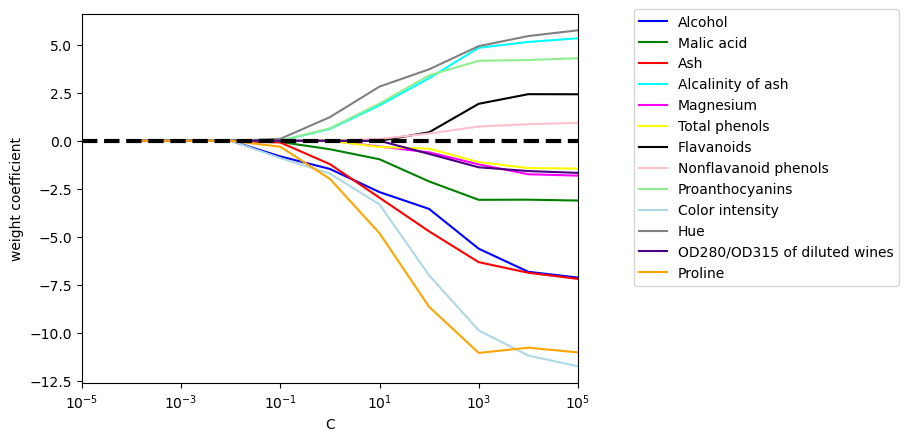

In [22]:
from sklearn.linear_model import LogisticRegression
fig = plt.figure()
ax = plt.subplot(111)

colors = ['blue', 'green', 'red', 'cyan',
         'magenta', 'yellow', 'black',
         'pink', 'lightgreen', 'lightblue',
         'gray', 'indigo', 'orange']
weights, params = [], []
for c in np.arange(-4., 6.):
    lr = LogisticRegression(penalty='l1', C=10.**c,
                            solver='liblinear',
                            multi_class='ovr', random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)
    
weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             label=df_wine.columns[column + 1],
             color=color)

plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**-5, 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center',
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)
plt.show()

# Feature Selection with Sequential Backward Selection

In [27]:
from sklearn.base import clone
from itertools import combinations
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

class SBS:
    def __init__(self, estimator, k_features,
                 scoring=accuracy_score, 
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
    
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train,
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]
        
        while dim > self.k_features:
            scores = []
            subsets = []
            
            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train, y_train,
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            
            self.scores_.append(scores[best])
        self.k_scores_ = self.scores_[-1]
        
        return self
    
    def transform(self, X):
        return X[:, self.indices_]
    
    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

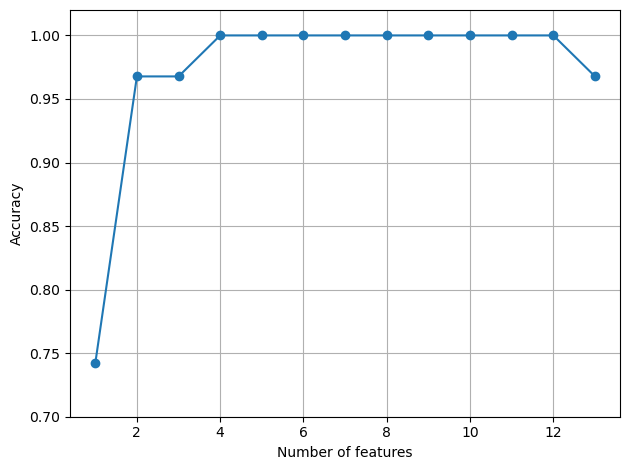

In [28]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)
k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show()

# Feature Selection with Random Forest Model

 1) Color intensity                0.172994
 2) Proline                        0.154752
 3) Alcohol                        0.138280
 4) Flavanoids                     0.137927
 5) OD280/OD315 of diluted wines   0.120440
 6) Hue                            0.083862
 7) Total phenols                  0.046418
 8) Magnesium                      0.034068
 9) Alcalinity of ash              0.031147
10) Malic acid                     0.028834
11) Proanthocyanins                0.025277
12) Ash                            0.014972
13) Nonflavanoid phenols           0.011029


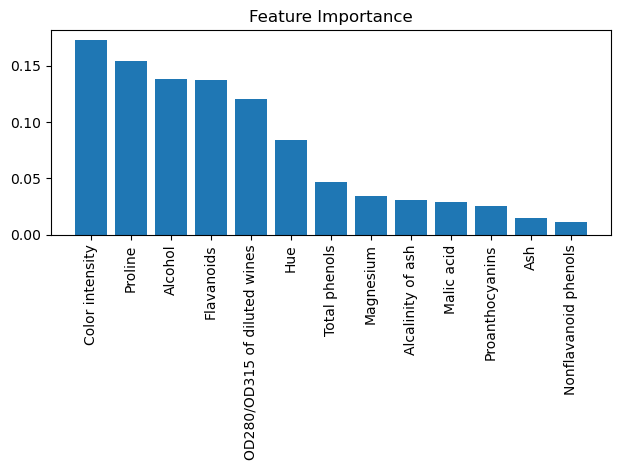

In [23]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_wine.columns[1:]
forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[indices[f]],
                            importances[indices[f]]))

plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]),
        importances[indices],
        align='center')
plt.xticks(range(X_train.shape[1]),
           feat_labels[indices],
           rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
